# EnzymeML data modelling workflow
> Data: Absorption over time corresponding to substrate concentration <br>
Data extraction: [API read request]( https://enzml.sloppy.zone/swagger-ui/) <br>
Models: irreversible Michaelis Menten (MM), MM with bias, MM with lag, MM with bias and lag <br>
Python packages for modelling: SciPy, lmfit and numpy<br>

This Jupyter Notebook demonstrates one workflow to access and use data stored in an EnzymeML document. <br>
Stephan Malzacher provided us with the data.  <br>
The time course data will be visualized, and the parameters of different kinetic models will be fitted against the data. <br>

### Imports
The following python packages are needed to run this Jupyter Notebook. <br>
For better readability, some functions have been moved to a separate python file. Those are imported here: `from utilities.jsonhelper import JSONHelper` and `from utilities.modeler import Modeler`

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit

from utilities.jsonhelper import JSONHelper
from utilities.modeler import Modeler

# initialize helpers
jsonH = JSONHelper("https://enzml.sloppy.zone/")
md = Modeler()

## Select EnzymeML document
Select the EnzymeML document by changing the path variable accordingly. <br>
> path = 'subfolder/filename.omex' <br> 
path = 'datasets/pH optimum 7.omex' <br> 

The EnzymeML document is sent to the EnzymeML API by running the next code cell, and the stored information is returned in a JSON format. The JSONHelper creates an object containing all data.<br>
This object is stored in the enzmldoc variable. <br>
If no errors occur, you get a short overview; otherwise, it prints an error message. In this case, please check if the file path is correct and that the [API-server]( https://enzml.sloppy.zone/swagger-ui/) can be reached. 

In [2]:
path = 'datasets/pH optimum 7.omex'

# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    readreq = jsonH.readRequest(path)
    if readreq == 200:
        enzmldoc = jsonH.getEnzmlJSON()
        print(enzmldoc)
    else:
        print('Error:'+str(readreq))
else:
    print('Incorrect file path.')

Title: pH optimum 7
Proteins: 
	ID: p0 	 Name: HcAHAS_C_unit
Reactants: 
	ID: s0 	 Name: pyruvate
	ID: s1 	 Name: acetolactate
	ID: s2 	 Name: Flavin dunucleotide
	ID: s3 	 Name: Magnesium sulfide
Reactions: 
Name: pH measurment 	 ID: r0
>>> Educts: 
	ID: s0 	 Name: pyruvate
>>> Products: 
	ID: s1 	 Name: acetolactate
>>> Modifiers: 
	ID: s2 	 Name: Flavin dunucleotide
	ID: p0 	 Name: HcAHAS_C_unit


## Visualisation of time course data


In [3]:
# get time course data as np array 
time, data_measured = enzmldoc.getData('r0','s0')

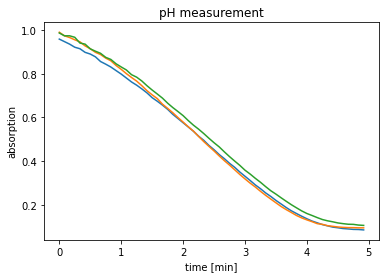

In [4]:
# plot time course data with matplotlib
plt.figure()
ax = plt.subplot()
for i in range(data_measured.shape[0]):
    ax.plot(time, data_measured[i, :], label='repl '+str(i+1))
ax.set_xlabel('time [min]')
ax.set_ylabel('absorption')
plt.title('pH measurement')
plt.show()

## Kinetic modelling


### Define the ODE functions

In [5]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Differential equation
    Arguments:
        w: vector of state variables: w = [S]
        t: time
        params: parameters object from lmfit
    '''
    S = w
    
    vmax = params['vmax'].value
    Km = params['Km'].value
    
    # f(S'):
    f = -vmax*S/(Km+S) # dS/dt
    
    return f

def iMM_with_lag(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [v,S]
        t: time
        params: parameters object from lmfit
    '''
    v, S = w
    
    a = params['a'].value
    vmax = params['vmax'].value
    Km = params['Km'].value
    
    # f(v', S'):
    f0 = a*(vmax-v) # dv/dt
    f1 = -v*S/(Km+S) # dS/dt
    
    return [f0,f1]

### Initialise parameters


In [6]:
s0 = md.get_initial_S0(data_measured)
bias = md.get_initial_bias(data_measured)
vmax = md.get_initial_vmax(time, data_measured)
km = md.get_initial_Km(time, data_measured)

# Parameters for irreversible Michaelis Menten without lag or bias
params_MM = Parameters()
params_MM.add('S0', value=s0, min=0.1, max=s0+0.2*s0)
params_MM.add('vmax', value=vmax, min=0.0001, max=10.)
params_MM.add('Km', value=km, min=0.0001, max=s0)

# Parameters for Michaelis Menten with bias
params_with_bias = Parameters()
params_with_bias.add('S0', value=s0-bias, min=0.1, max=s0)
params_with_bias.add('bias', value=bias, min=0.001, max=s0*0.5)
params_with_bias.add('vmax', value=vmax, min=0.0001, max=10.)
params_with_bias.add('Km', value=km, min=0.0001, max=s0)

# Parameters for Michaelis Menten with lag
params_with_lag = Parameters()
params_with_lag.add('v0', value=0, vary=False)
params_with_lag.add('S0', value=s0, min=0.1, max=s0+0.2*s0)
params_with_lag.add('a', value=1., min=0.0001, max=10.)
params_with_lag.add('vmax', value=vmax, min=0.0001, max=10.)
params_with_lag.add('Km', value=km, min=0.0001, max=s0)

# Parameters for Michaelis Menten with lag and bias
params_with_lag_bias = Parameters()
params_with_lag_bias.add('v0', value=0, vary=False)
params_with_lag_bias.add('S0', value=s0-bias, min=0.1, max=s0)
params_with_lag_bias.add('bias', value=bias, min=0.001, max=s0*0.5)
params_with_lag_bias.add('a', value=1., min=0.0001, max=10.)
params_with_lag_bias.add('vmax', value=vmax, min=0.0001, max=10.)
params_with_lag_bias.add('Km', value=km, min=0.0001, max=s0)

### Fit models

In [7]:
# irreversible Michaelis Menten
result_MM = md.fit_model(time, data_measured, params_MM, irreversible_Michaelis_Menten)

# Michaelis Menten with bias
result_MM_with_bias = md.fit_model(time, data_measured, params_with_bias, irreversible_Michaelis_Menten)

# Michaelis Menten with lag
result_MM_with_lag = md.fit_model(time, data_measured, params_with_lag, iMM_with_lag)

# Michaelis Menten with lag and bias
result_with_lag_bias = md.fit_model(time, data_measured, params_with_lag_bias, iMM_with_lag)

### Results with plots

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 180
    # variables        = 3
    chi-square         = 0.13461421
    reduced chi-square = 7.6053e-04
    Akaike info crit   = -1289.69385
    Bayesian info crit = -1280.11498
[[Variables]]
    S0:    1.03344703 +/- 0.00545727 (0.53%) (init = 0.9780667)
    vmax:  0.26212654 +/- 0.00752399 (2.87%) (init = 0.2668)
    Km:    0.09607263 +/- 0.01484151 (15.45%) (init = 0.04726667)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.962
    C(S0, vmax) =  0.746
    C(S0, Km)   =  0.581


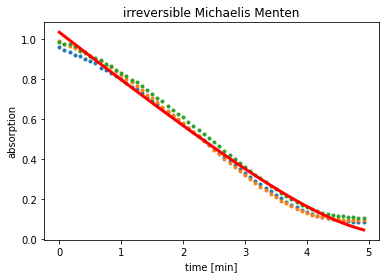

In [8]:
result = result_MM
report_fit(result)
w0 = result.params['S0'].value
data_fitted = md.solveODE(irreversible_Michaelis_Menten, time, w0, result.params)
plt.figure()
ax = plt.subplot()
for i in range(data_measured.shape[0]):
    ax.plot(time, data_measured[i, :], 'o', ms=3, label='repl '+str(i+1))
ax.plot(time, data_fitted[:], '-', linewidth=3, color='red', label='fitted data')
ax.set_xlabel('time [min]')
ax.set_ylabel('absorption')
plt.title('irreversible Michaelis Menten')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 180
    # variables        = 4
    chi-square         = 0.08045447
    reduced chi-square = 4.5713e-04
    Akaike info crit   = -1380.34373
    Bayesian info crit = -1367.57190
[[Variables]]
    S0:    0.91874326 +/- 0.00556553 (0.61%) (init = 0.8834)
    bias:  0.10519338 +/- 0.00390481 (3.71%) (init = 0.09466667)
    vmax:  0.22528129 +/- 0.00322437 (1.43%) (init = 0.2668)
    Km:    0.00173552 +/- 0.00408760 (235.53%) (init = 0.04726667)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.888
    C(S0, bias) = -0.711
    C(S0, vmax) =  0.563
    C(S0, Km)   =  0.367


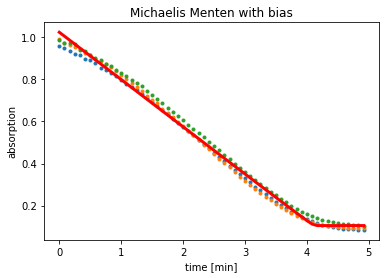

In [9]:
result = result_MM_with_bias
report_fit(result)
w0 = result.params['S0'].value
data_fitted = md.solveODE(irreversible_Michaelis_Menten, time, w0, result.params)
plt.figure()
ax = plt.subplot()
for i in range(data_measured.shape[0]):
    ax.plot(time, data_measured[i, :], 'o', ms=3, label='repl '+str(i+1))
ax.plot(time, data_fitted[:]+result.params['bias'].value, '-', linewidth=3, color='red', label='fitted data')
ax.set_xlabel('time [min]')
ax.set_ylabel('absorption')
plt.title('Michaelis Menten with bias')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 180
    # variables        = 4
    chi-square         = 0.05793467
    reduced chi-square = 3.2917e-04
    Akaike info crit   = -1439.45130
    Bayesian info crit = -1426.67947
[[Variables]]
    v0:    0 (fixed)
    S0:    0.95065623 +/- 0.00409304 (0.43%) (init = 0.9780667)
    a:     0.85668633 +/- 0.16143607 (18.84%) (init = 1)
    vmax:  0.59403350 +/- 0.12494890 (21.03%) (init = 0.2668)
    Km:    0.50310373 +/- 0.14084696 (28.00%) (init = 0.04726667)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) =  0.995
    C(a, vmax)  = -0.979
    C(a, Km)    = -0.956
    C(S0, a)    =  0.642
    C(S0, vmax) = -0.534
    C(S0, Km)   = -0.492


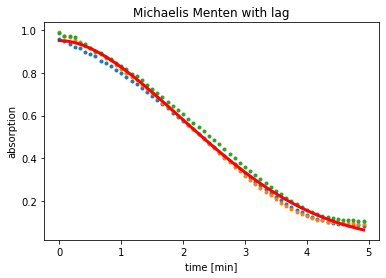

In [10]:
result = result_MM_with_lag
report_fit(result)
w0 = result.params['v0'].value, result.params['S0'].value
data_fitted = md.solveODE(iMM_with_lag, time, w0, result.params)
plt.figure()
ax = plt.subplot()
for i in range(data_measured.shape[0]):
    ax.plot(time, data_measured[i, :], 'o', ms=3, label='repl '+str(i+1))
ax.plot(time, data_fitted[:, 1], '-', linewidth=3, color='red', label='fitted data')
ax.set_xlabel('time [min]')
ax.set_ylabel('absorption')
plt.title('Michaelis Menten with lag')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 180
    # variables        = 5
    chi-square         = 0.04123983
    reduced chi-square = 2.3566e-04
    Akaike info crit   = -1498.63538
    Bayesian info crit = -1482.67059
[[Variables]]
    v0:    0 (fixed)
    S0:    0.86085394 +/- 0.00534280 (0.62%) (init = 0.8834)
    bias:  0.09725100 +/- 0.00436836 (4.49%) (init = 0.09466667)
    a:     1.69790846 +/- 0.15518051 (9.14%) (init = 1)
    vmax:  0.28159299 +/- 0.01082284 (3.84%) (init = 0.2668)
    Km:    0.04761832 +/- 0.01094640 (22.99%) (init = 0.04726667)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km)   =  0.947
    C(a, vmax)    = -0.895
    C(a, Km)      = -0.743
    C(S0, bias)   = -0.736
    C(bias, Km)   = -0.638
    C(bias, vmax) = -0.504
    C(bias, a)    =  0.333
    C(S0, Km)     =  0.312
    C(S0, a)      =  0.211
    C(S0, vmax)   =  0.122


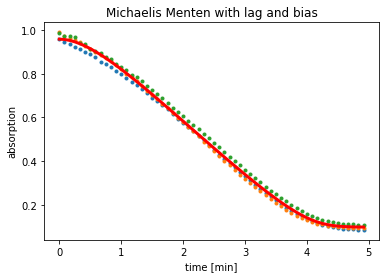

In [11]:
result = result_with_lag_bias
report_fit(result)
w0 = result.params['v0'].value, result.params['S0'].value
data_fitted = md.solveODE(iMM_with_lag, time, w0, result.params)
plt.figure()
ax = plt.subplot()
for i in range(data_measured.shape[0]):
    ax.plot(time, data_measured[i, :], 'o', ms=3, label='repl '+str(i+1))
ax.plot(time, data_fitted[:, 1]+result.params['bias'].value, '-', linewidth=3, color='red', label='fitted data')
ax.set_xlabel('time [min]')
ax.set_ylabel('absorption')
plt.title('Michaelis Menten with lag and bias')
plt.show()